## Initialization steps

### Library Imports

We are importing Tensorflow and keras libraries to build and run our models.
 
We are processing and loading audio data with the help of librosa and torch libraries.

In [ ]:
# install audio augmentation library from git
!pip install git+https://github.com/Spijkervet/torchaudio-augmentations.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Spijkervet/torchaudio-augmentations.git to /tmp/pip-req-build-monhkoz9
  Running command git clone -q https://github.com/Spijkervet/torchaudio-augmentations.git /tmp/pip-req-build-monhkoz9
     |████████████████████████████████| 59 kB 7.8 MB/s 
  Created wheel for torchaudio-augmentations: filename=torchaudio_augmentations-0.2.4-py3-none-any.whl size=12205 sha256=217065d76e2ef14de823878b91879a7902f906155f9fa15f46b82646087549aa
  Stored in directory: /tmp/pip-ephem-wheel-cache-ljtvnc4c/wheels/b9/c0/34/288be56ea8ab6e9c7fbd24db975feed9aedfe2089f242cccad
  Created wheel for julius: filename=julius-0.2.7-py3-none-any.whl size=21895 sha256=b9679ab22487d59b97a513d1472ff57cf4e5563cb3e061dbe2287bc0783119f0
  Stored in directory: /root/.cache/pip/wheels/85/89/4f/88596b58a42ee452100fe1cd6ac31265bb192e597cf85908da
Successfully built torchaudio-augmentations julius


In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
import tensorflow.keras.layers
from tensorflow.keras.layers import Reshape, Permute, GRU
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Flatten, Dropout, LSTM
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [ ]:
import json
import os
import math
import torchaudio
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
import torch
import torchaudio
import torchaudio.transforms
#from torchaudio_augmentations import *
import random
from tqdm import tqdm
import seaborn as sn
import pandas as pd
from sklearn import preprocessing
from sklearn.decomposition import PCA

### Connect to Google Drive

We will use Google colab to run our code and store all data in a shared folder on our Google Drive. In order to easily access all files, we first need to set up a connection to our drive.

Note: if you want to run the notebook and access our data, please use the following link https://drive.google.com/drive/folders/1AiGAaLyv-pXg24BDtOOFa-KChQV0qXH2?usp=sharing and add is as a shortcut to your drive (see screenshot)
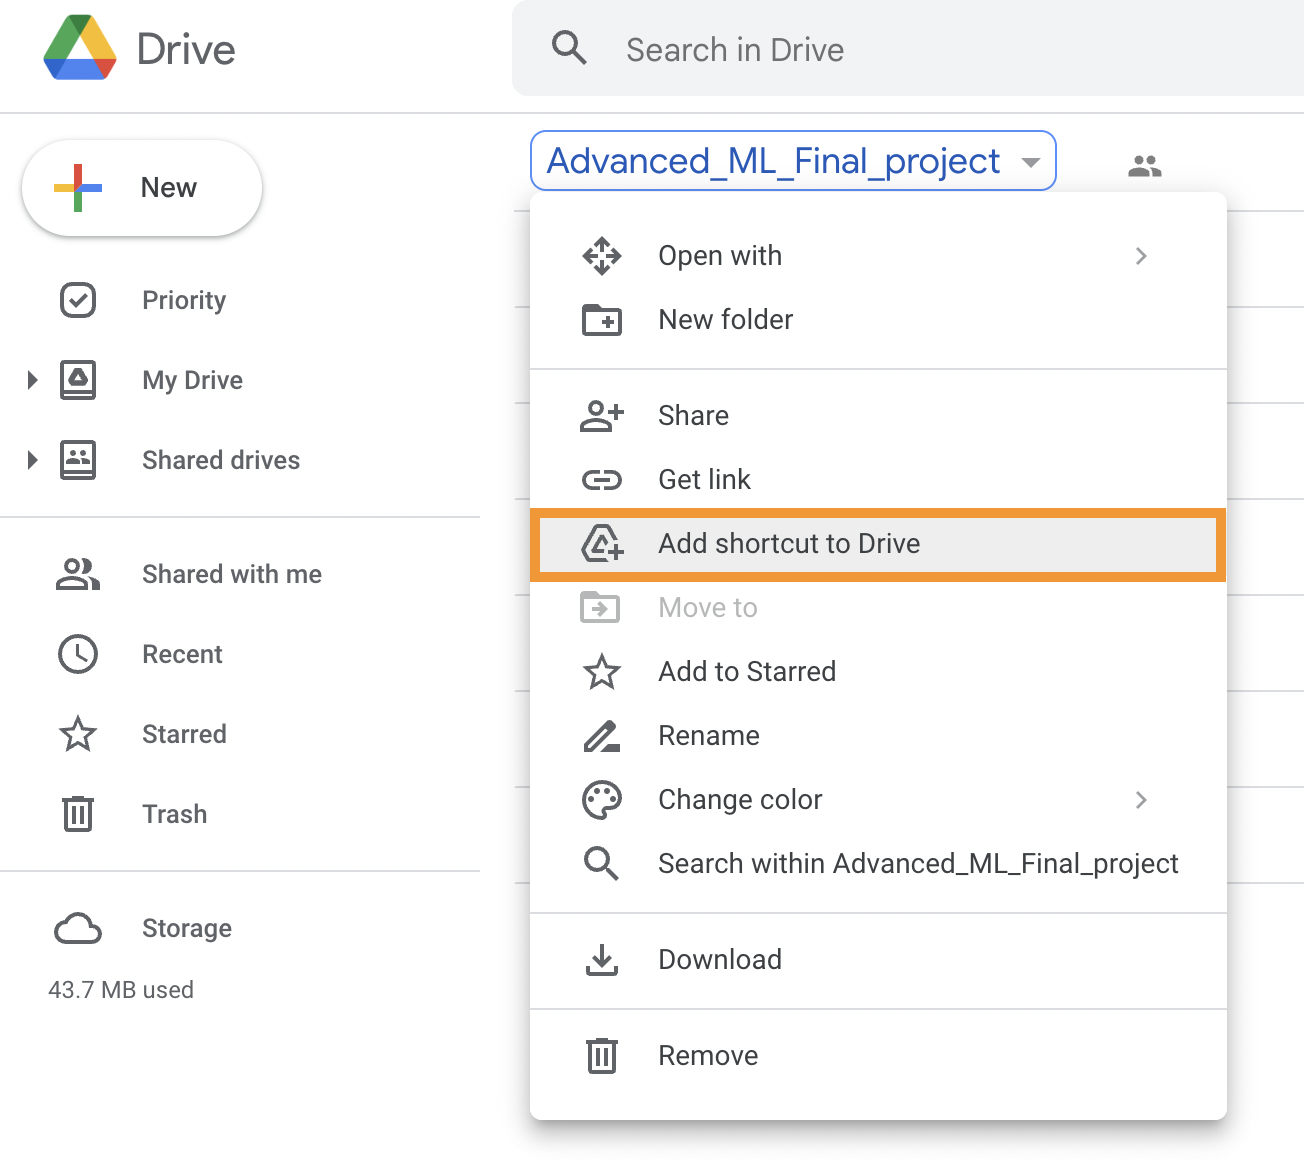

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

root_path = '/content/drive/My Drive/Advanced_ML_Final_project'

Mounted at /content/drive


### General Parameters

Used to define some general parameters that are needed for EDA, the intital dataload as well as some steps in the data Preprocessing.

In [ ]:
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
hop_length = 512 # in num. of samples
n_fft = 2048 # window in num. of samples

## EDA

Before starting with our experimentation, we need to develop a first understanding for audio data.
Therefore, we dive into some terminology and provide some plots on an exemplary data point to illustrate the underlying concepts in this section. 

Inspiration for our EDA was taken from https://www.kaggle.com/code/aishwarya2210/let-s-tune-the-music-with-cnn-xgboost

In [ ]:
# Importing 1 examplary file
y, sr = librosa.load(f'{root_path}/data/genres_original/reggae/reggae.00036.wav', sr=None)

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample Rate (KHz):', sr, '\n')

# Verify length of the audio
print('Check Len of Audio:', 661794/22050)

y: [0.02072144 0.04492188 0.05422974 ... 0.06912231 0.08303833 0.08572388] 

y shape: (661794,) 

Sample Rate (KHz): 22050 

Check Len of Audio: 30.013333333333332


### Raw waveform

In the first part of the EDA, we want to look at the raw waveform to get a better understanding of some key terms in the field of audio data:

*   Frequency (measured in Hz): differences of wave lengths; High frequency = short wavelength = higher tone; Frequency spectrum: Lows aka Bass, Mids and Highs. Only a certain spectrum (20Hz-20KHz) audible for humans; For further explanation on frequency, look here: https://www.headphonesty.com/2020/02/audio-frequency-spectrum-explained/ and here: https://www.earmaster.com/music-theory-online/ch03/chapter-3-1.html
*   Intensity (measured in db/power): the amplitude (height) of the wave (loudness); How high each of the wave reaches; typically Bass and Highs are louder than Mids
*   Sample rate (measured in KHz): specific to how the computer reads in the audio file. The "resolution" of the audio, discrete observations of the audio file. Sample rate measures how frequent these observations are. The quality/detail of the audio file.

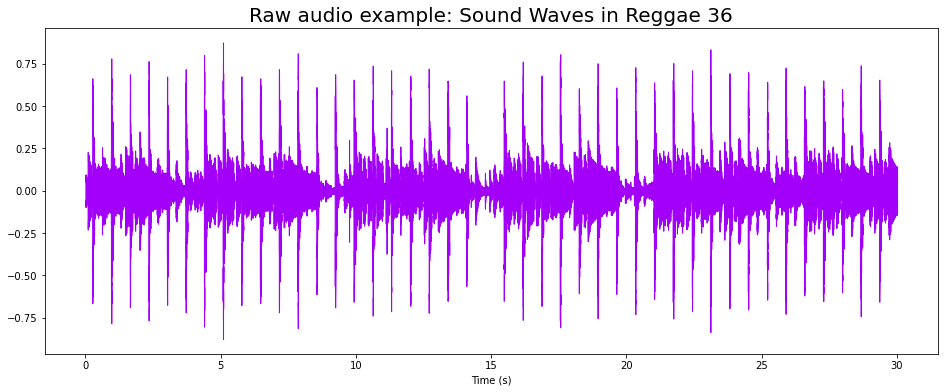

In [ ]:
# plot raw waveform
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = y, sr = sr, color = "#A300F9", x_axis = 's');
plt.title("Raw audio example: Sound Waves in Reggae 36", fontsize = 20);

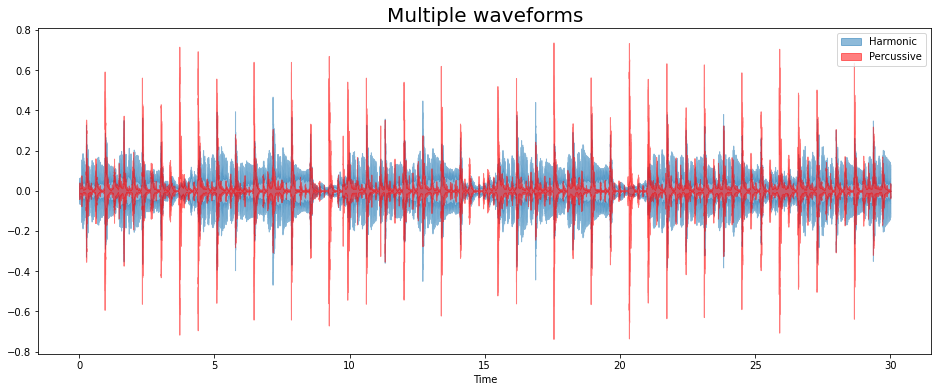

In [ ]:
# plot raw waveform grouped by type
y_harm, y_perc = librosa.effects.hpss(y)
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y_harm, sr=sr, alpha=0.5, label='Harmonic')
librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.5, label='Percussive')
plt.title('Multiple waveforms', fontsize = 20)
plt.legend();

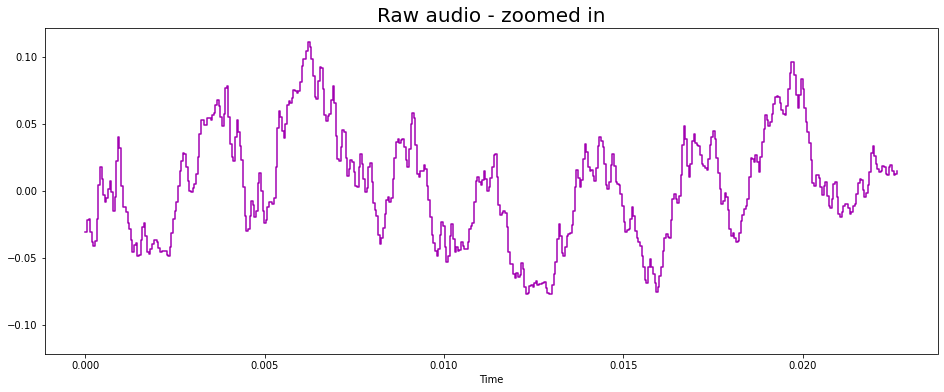

In [ ]:
# plot zoomed in raw audio
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = y[30000:30500], sr = sr, color = "#A100B1");
plt.title("Raw audio - zoomed in", fontsize = 20);

### Spectogram representation

Next, we want to dive a little into spectogram representations which will be used as the input for our models in the later steps.

A Spectogram is a visualization of audio that looks at different frequencies by how powerful they are.

Here, we briefly illustrate two types of spectograms: melspectograms and MFCCs which are just a smoothed version of the first type.

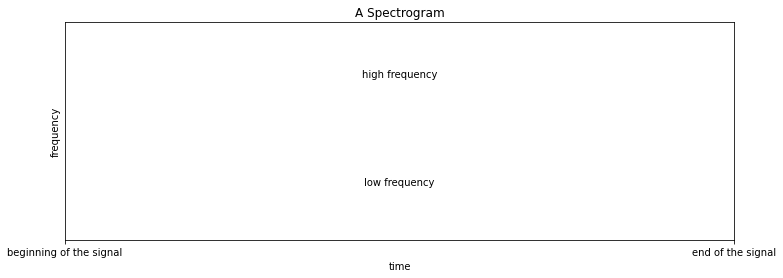

In [ ]:
# plot general setup of a spectogram
plt.figure(figsize=(12, 4))
plt.plot()
plt.xlabel('time'); plt.ylabel('frequency')
plt.xlim([-2, 2]); plt.ylim([-2, 2])
plt.grid(False)
plt.text(0, -1, 'low frequency', ha='center')
plt.text(0, 1, 'high frequency', ha='center')
plt.xticks([-2, 2], ['beginning of the signal', 'end of the signal']);plt.yticks([]);
# plt.text(-2, -1.5, 'beginning of the signal')
plt.title('A Spectrogram');

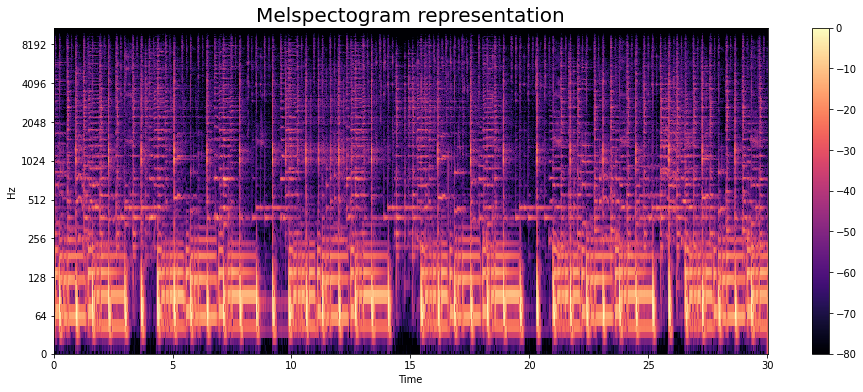

In [ ]:
# transform y into melspectogram represenation
y_melspec = librosa.amplitude_to_db(np.abs(librosa.stft(y) ), ref=np.max)

# plot melspectogram
plt.figure(figsize = (16, 6))
librosa.display.specshow(y_melspec, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'log')
plt.colorbar()
plt.title("Melspectogram representation", fontsize = 20);

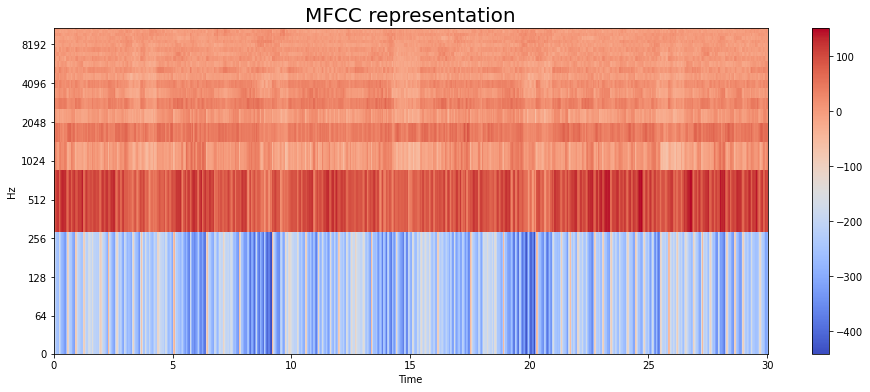

In [ ]:
# transform y into MFCC represenation
y_mfcc = librosa.feature.mfcc(y=y, sr=sr)

# plot MFCC
plt.figure(figsize = (16, 6))
librosa.display.specshow(y_mfcc, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'log')
plt.colorbar()
plt.title("MFCC representation", fontsize = 20);

### Meta data

Even if we don't further use metadata for the training of our models, it can be a good indicator for the similarities and differences between the classes.
Therefore, in this last part of the EDA, we have a brief look at metadata of the audio data and finally perform a PCA on it.

In [ ]:
# show top rows of the metadata dataframe 
meta = pd.read_csv(f'{root_path}/data/features_30_sec.csv')
meta.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


<ipython-input-21-08d7e7f87e9e>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


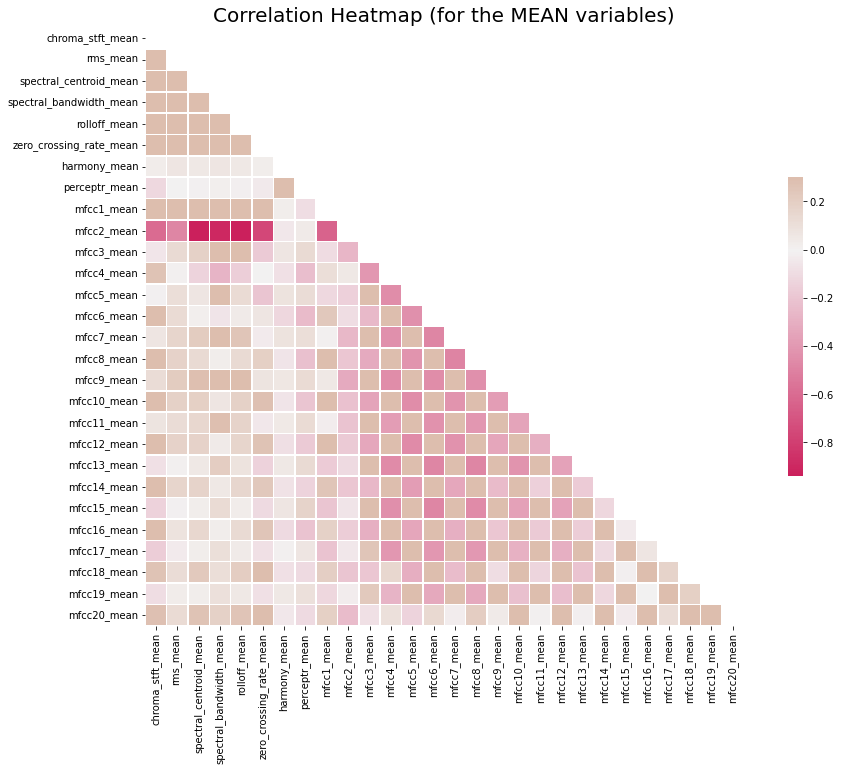

In [ ]:
# Computing the Correlation Matrix
spike_cols = [col for col in meta.columns if 'mean' in col]
corr = meta[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sn.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

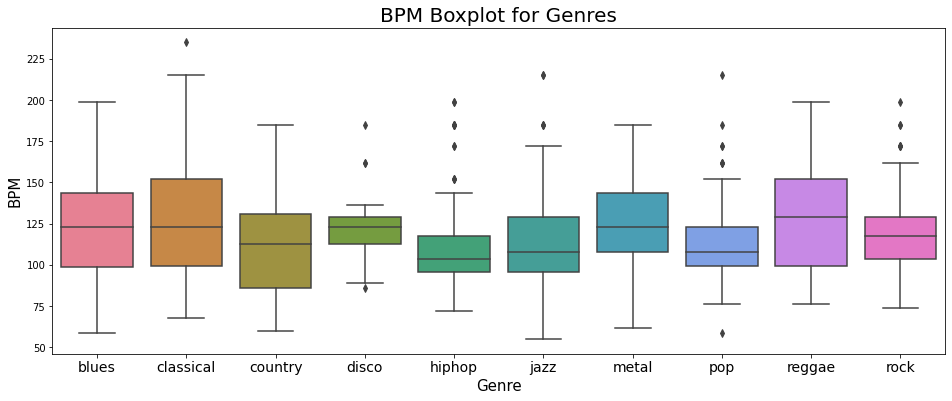

In [ ]:
# Boxplot for the BPM per genre
x = meta[["label", "tempo"]]

f, ax = plt.subplots(figsize=(16, 6));
sn.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15);

In [ ]:
# Perform PCA
meta = meta.iloc[0:, 18:]
y = meta['label']
X = meta.loc[:, meta.columns != 'label']

#### NORMALIZE X ####
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

#### PCA 2 COMPONENTS ####
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

print("Explained variance:",pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1])

Explained variance: 0.45657279728092565


In [ ]:
meta.iloc[0:, 18:]

,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-153.640961,2540.949463,109.864647,455.579956,-23.065695,189.883865,59.050125,132.334518,-7.475873,92.553497,...,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock
996,-142.392029,3282.358887,116.189629,345.518890,-32.147167,191.464813,49.117840,66.674255,-8.373376,81.370674,...,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock
997,-124.952271,1681.638794,115.177155,475.088074,-47.975151,290.302795,52.814674,113.682693,-13.484810,77.294281,...,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock
998,-225.007751,10766.367188,123.646751,492.819122,-9.724174,605.487488,56.605164,189.945770,10.436500,156.834641,...,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock


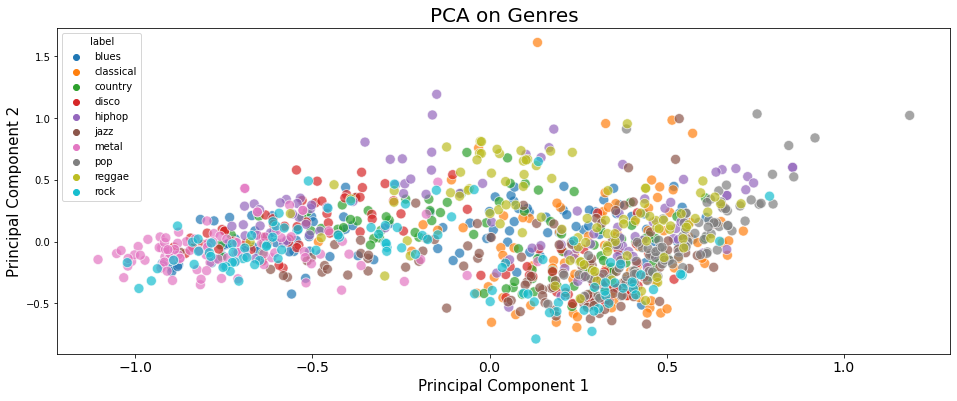

In [ ]:
# Visualize PCA results
plt.figure(figsize = (16, 6))
sn.scatterplot(x = "principal component 1", y = "principal component 2", data = finalDf, hue = "label", alpha = 0.7,
               s = 100);

plt.title('PCA on Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15);

## Initial Data load


To start off, we firstly need to load the audio files from the Drive. We store the audio data ("tracks") alongside with the respective labels, a mapping which tells us which label is associated to which genre and finally the filenames (for sanity checking) in a dictionary.

The code is built in a way that we can choose in how many segments each track should be split.

Since the dataload is relatively memory intensive, we only ran it once in the beginning to store the data in a more comprise format, which is easier to load in the notebook.

Thus, the code block used for the dataload is commented out so we make sure not running it again by acccident.

In [ ]:
# data load parameters
dataset_path = root_path + '/data/genres_original'
num_segments = 1
SAMPLES_PER_SEGMENT = int(SAMPLES_PER_TRACK / num_segments)

In [ ]:
'''data = {
    "mapping": [],
    "labels": [],
    "tracks": []
    "filenames": []
    }


#num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

# loop through all genre sub-folder
for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
    # ensure we're processing a genre sub-folder level
    if dirpath is not dataset_path:

        # save genre label (i.e., sub-folder name) in the mapping
        semantic_label = dirpath.split("/")[-1]
        data["mapping"].append(semantic_label)
        print("\nProcessing: {}".format(semantic_label))

        # ONLY TO REDUCE NUMBER OF DATA POINTS WHEN TESTING - DELETE WHEN TRAINING MODEL
        #if semantic_label == "reggae":
        #    break

        # process all audio files in genre sub-dir
        for f in filenames:

	        # load audio file
            file_path = os.path.join(dirpath, f)
            track, sample_rate = torchaudio.load(file_path)

            # process all segments of audio file
            for d in range(num_segments):

                # calculate start and finish sample for current segment
                start = SAMPLES_PER_SEGMENT * d
                finish = start + SAMPLES_PER_SEGMENT
                if track.shape[1] < SAMPLES_PER_TRACK and d == num_segments-1:
                    # need to include padding
                    track_segment = torch.nn.functional.pad(track[:,start:],(0,SAMPLES_PER_TRACK-track.shape[1]))
                elif track.shape[1] > SAMPLES_PER_TRACK and d == num_segments-1:
                    track_segment = track[:,start:SAMPLES_PER_TRACK]
                else:
                    track_segment = track[:,start:finish]

                data["tracks"].append(track_segment.tolist())
                data["labels"].append(i-1)
                data["filenames"].append(f)
                #print("{}, segment:{}".format(file_path, d+1))'''

'data = {\n    "mapping": [],\n    "labels": [],\n    "tracks": []\n    "filenames": []\n    }\n\n\n#num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)\n\n# loop through all genre sub-folder\nfor i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):\n    # ensure we\'re processing a genre sub-folder level\n    if dirpath is not dataset_path:\n\n        # save genre label (i.e., sub-folder name) in the mapping\n        semantic_label = dirpath.split("/")[-1]\n        data["mapping"].append(semantic_label)\n        print("\nProcessing: {}".format(semantic_label))\n\n        # ONLY TO REDUCE NUMBER OF DATA POINTS WHEN TESTING - DELETE WHEN TRAINING MODEL\n        #if semantic_label == "reggae":\n        #    break\n\n        # process all audio files in genre sub-dir\n        for f in filenames:\n\n\t        # load audio file\n            file_path = os.path.join(dirpath, f)\n            track, sample_rate = torchaudio.load(file_path)\n\n          

## Preprocessing

After the data is loaded, it goes through 2-3 Preprocessing steps (depending on which dataset variant we are looking at) needed to prepare the data for the modelling.

### Split data

The first step that is needed for all dataset variants is the splitting of the data.
To achieve this, the data and the associated labels are first shuffled using a random seed to ensure reproducibility, and then split into train, validation, and test set using a 80:10:20 split ratio respectively.

Afterwards, each chunk of our original data is converted into a tensor and stored on our drive. From this stage, the splits can be easily load into the notebook (EDIT: X splits have been deleted from Drive as they took up too much storage in this format, therefore, data loads associated with those splits are commented out. y splits can still be loaded for visualization purposes.)

At the end of this section, we further added some visualizations for the class balance in each split to get an overview of the class distribution.

In [ ]:
# shuffle data - we included "filenames" here just for sanity checking between the label and the filename (which always contains the name of the genre) after shuffling
#temp = list(zip(data["tracks"],data["labels"],data["filenames"]))

#random.seed(42) # ensures reproducible results
#random.shuffle(temp)

#tracks, labels, filenames = zip(*temp)

In [ ]:
# train test val split 80:10:20
#X_train = torch.tensor(tracks[:int(len(tracks)*0.7)])
#y_train = torch.tensor(labels[:int(len(labels)*0.7)])

#X_val = torch.tensor(tracks[int(len(tracks)*0.7):int(len(tracks)*0.8)])
#y_val = torch.tensor(labels[int(len(labels)*0.7):int(len(labels)*0.8)])

#X_test = torch.tensor(tracks[int(len(tracks)*0.8):])
#y_test = torch.tensor(labels[int(len(labels)*0.8):])

In [ ]:
# save splits
#torch.save(X_train,root_path+"/data_preprocessed/X_train_full_track.pt")
#torch.save(y_train,root_path+"/data_preprocessed/y_train_full_track.pt")

#torch.save(X_val,root_path+"/data_preprocessed/X_val_full_track.pt")
#torch.save(y_val,root_path+"/data_preprocessed/y_val_full_track.pt")

#torch.save(X_test,root_path+"/data_preprocessed/X_test_full_track.pt")
#torch.save(y_test,root_path+"/data_preprocessed/y_test_full_track.pt")

In [ ]:
# Fast track for split data
#X_train = torch.load(root_path+"/data_preprocessed/X_train_full_track.pt")
y_train = torch.load(root_path+"/data_preprocessed/y_train_full_track.pt")

#X_val = torch.load(root_path+"/data_preprocessed/X_val_full_track.pt")
y_val = torch.load(root_path+"/data_preprocessed/y_val_full_track.pt")

#X_test = torch.load(root_path+"/data_preprocessed/X_test_full_track.pt")
y_test = torch.load(root_path+"/data_preprocessed/y_test_full_track.pt")

In [ ]:
# calculate class balance for each split
labels = [i for i in range(10)]
mapping = ["pop","metal","disco","blues","reggae","classical","rock","hiphop","country","jazz"] # only needed when dataload has not been run again before

train_label_occ = [np.array(y_train == i).sum() for i in range(10)]
train_label_occ_rel = [occ/sum(train_label_occ) for occ in train_label_occ]

val_label_occ = [np.array(y_val == i).sum() for i in range(10)]
val_label_occ_rel = [occ/sum(val_label_occ) for occ in val_label_occ]

test_label_occ = [np.array(y_test == i).sum() for i in range(10)]
test_label_occ_rel = [occ/sum(test_label_occ) for occ in test_label_occ]

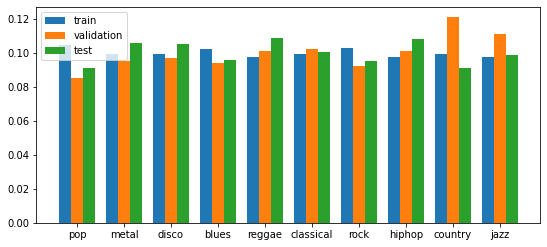

In [ ]:
# visualize class balance across splits
data = [train_label_occ_rel,
val_label_occ_rel,
test_label_occ_rel]
X = np.arange(10)
fig = plt.figure(figsize=(7,3))
ax = fig.add_axes([0,0,1,1])
ax.bar(X - 0.25, data[0], width = 0.25, label="train")
ax.bar(X + 0.00, data[1], width = 0.25, label="validation")
ax.bar(X + 0.25, data[2], width = 0.25, label="test")
plt.xticks(labels, labels=mapping)
ax.legend()
#plt.savefig(root_path+"/Images/class_balance_across_splits_3_sec")

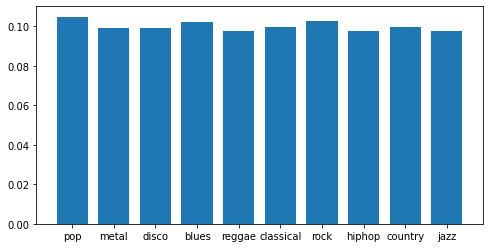

In [ ]:
# visualize class balance for the train set
fig = plt.figure(figsize=(8,4))
plt.bar(labels,train_label_occ_rel, width=0.75, tick_label=mapping)
#plt.savefig(root_path+"/Images/class_balance_rel_train_3_sec")

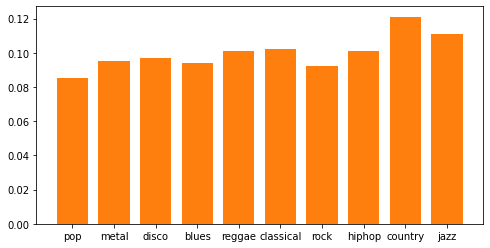

In [ ]:
# visualize class balance for the validation set
fig = plt.figure(figsize=(8,4))
plt.bar(labels,val_label_occ_rel, width=0.75, color='#ff7f0e', tick_label=mapping)
#plt.savefig(root_path+"/Images/class_balance_rel_val__3_sec")

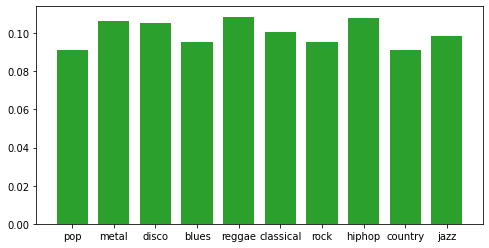

In [ ]:
# visualize class balance for the test set
fig = plt.figure(figsize=(8,4))
plt.bar(labels,test_label_occ_rel, width=0.75, color='#2ca02c', tick_label=mapping)
#plt.savefig(root_path+"/Images/class_balance_rel_test_3_sec")

### Augmentation
(optional)

Data Augmentation is a technique often used to render models more generalizable i.e. reduce overfitting. Thereby, we create different versions for each datapoint in the train set containing small distortions which make it harder (but not impossible) to classify them correctly.

For the sake of this project, we use Spijkervet's torchaudio-augmentations library from git which provides various methods to augment audio data.
To get a better understanding how each of the different techniques changes the sound of each file, please refer to https://music-classification.github.io/tutorial/part3_supervised/data-augmentation.html. 

For our augmented datasets, we create 3 additional augmented variants for each data point in our train set. We explicitly decided against augmenting the validation and test set as both of them are supposed to represent real-life data which thus should not contain any unanticipated distortions.

Note that in case of the augmented data, we need to remember duplicating labels accordingly and do another round of shuffling on both the data and the labels afterwards in order to retain randomness in the data. Due to limited memory, this is only done after converting the augmented data points into MFCC representation as this format is less memory-intensive than the raw audio data.

Due to the immense runtime associated with the data augmentation, all execution steps were commented out. Augmented data can later - for the training of the model - be loaded directly from the drive.

In [ ]:
# initialize augmentation methods
transforms = [

    # add random noise to the signal in the range between min and max signal-to-noise ratio
    RandomApply([Noise(min_snr=0.3, max_snr=0.5)], p=0.3),

    # increase/decrease the intensity i.e amplitude and therefore the loudness of the signal
    RandomApply([Gain()], p=0.2),

    # stochastic Frequency filter which cuts off all signals above or below a threshold
    RandomApply([HighLowPass(sample_rate=SAMPLE_RATE)], p=0.8),

    # add a delayed signal to the original signal
    RandomApply([Delay(sample_rate=SAMPLE_RATE)], p=0.5),

    # add a reverb to the signal
    RandomApply([Reverb(sample_rate=SAMPLE_RATE)], p=0.3)
]

# function for augmenting a single data point
def augment(audio_tensor,num_aug_samples=3):
    augmented_tensors = torch.tensor(np.array([audio_tensor.numpy()]))
    augment = ComposeMany(transforms=transforms, num_augmented_samples=num_aug_samples)
    transformed_audios = augment(audio_tensor)
    augmented_tensors = torch.cat((augmented_tensors, transformed_audios), axis=0)
    return augmented_tensors

# function for batch Augmentation
def augment_batch(audio_tensors,num_aug_samples=3):
    augmented_tensors = torch.tensor([])
    for audio_tensor in tqdm(audio_tensors):
        augmented_tensors = torch.cat((augmented_tensors, augment(audio_tensor,num_aug_samples=num_aug_samples)),axis=0)
    return augmented_tensors

In [ ]:
# Augment train data - done chunkwise in order to avoid slowing down the program due to high memory usage during runtime
#X_train_augment_1 = augment_batch(X_train[:50])
#X_train_augment_2 = augment_batch(X_train[50:100])
#X_train_augment_3 = augment_batch(X_train[100:150])
#X_train_augment_4 = augment_batch(X_train[150:200])
#X_train_augment_5 = augment_batch(X_train[200:250])
#X_train_augment_6 = augment_batch(X_train[250:300])
#X_train_augment_7 = augment_batch(X_train[300:350])
#X_train_augment_8 = augment_batch(X_train[350:400])
#X_train_augment_9 = augment_batch(X_train[400:450])
#X_train_augment_10 = augment_batch(X_train[450:500])
#X_train_augment_11 = augment_batch(X_train[500:550])
#X_train_augment_12 = augment_batch(X_train[550:600])
#X_train_augment_13 = augment_batch(X_train[600:650])
#X_train_augment_14 = augment_batch(X_train[650:])

In [ ]:
# scale train labels
#y_train_augment = train_y.repeat_interleave(4)

### Spectogram transformation

In the last step of the Preprocessing, all raw data points were converted to spectograms - in this case, we decided for MFCC as a state-of-the-art format in audio classification.

Here, we rely on the implementations from the torchaudio library and vary between a number of MFCC coefficients of 20 and 40 for our experiments.

The results of this step are then again stored on the Drive to have them handy during the experimentation and avoid the necessity of walking through all steps again every time.

In [ ]:
# batch transformation for MFCC
def MFCC_batch(audio_tensors,sr=SAMPLE_RATE,n_mfcc=40):
    transform = torchaudio.transforms.MFCC(sr,n_mfcc=n_mfcc)
    mfccs = torch.tensor([])
    for at in tqdm(audio_tensors):
        mfccs = torch.cat((mfccs,transform(at)),axis=0)
    return mfccs

# batch transformation for melspectograms
def melspec_batch(audio_tensors,sr=SAMPLE_RATE):
    transform = torchaudio.transforms.MelSpectrogram(sr)
    melspecs = torch.tensor([])
    for at in tqdm(audio_tensors):
        melspecs = torch.cat((melspecs,transform(at)),axis=0)
    return melspecs

In [ ]:
# convert (unaugmented) train data batches - (again) done chunkwise in order to avoid slowing down the program due to high memory usage during runtime
#X_train_mfcc_1 = MFCC_batch(X_train[:50])
#X_train_mfcc_2 = MFCC_batch(X_train[50:100])
#X_train_mfcc_3 = MFCC_batch(X_train[100:150])
#X_train_mfcc_4 = MFCC_batch(X_train[150:200])
#X_train_mfcc_5 = MFCC_batch(X_train[200:250])
#X_train_mfcc_6 = MFCC_batch(X_train[250:300])
#X_train_mfcc_7 = MFCC_batch(X_train[300:350])
#X_train_mfcc_8 = MFCC_batch(X_train[350:400])
#X_train_mfcc_9 = MFCC_batch(X_train[400:450])
#X_train_mfcc_10 = MFCC_batch(X_train[450:500])
#X_train_mfcc_11 = MFCC_batch(X_train[500:550])
#X_train_mfcc_12 = MFCC_batch(X_train[550:600])
#X_train_mfcc_13 = MFCC_batch(X_train[600:650])
#X_train_mfcc_14 = MFCC_batch(X_train[650:])

# concat batches
#X_train_mfcc = torch.cat((X_train_mfcc_1,X_train_mfcc_2,X_train_mfcc_3,X_train_mfcc_4,X_train_mfcc_5,X_train_mfcc_6,X_train_mfcc_7,X_train_mfcc_8,X_train_mfcc_9,X_train_mfcc_10,X_train_mfcc_11,X_train_mfcc_12,X_train_mfcc_13,X_train_mfcc_14),axis=0)

#torch.save(X_train_mfcc,root_path+"/data_preprocessed/X_train_mfcc_full_track.pt")

In [ ]:
# convert augmented train data batches - (again) done chunkwise in order to avoid slowing down the program due to high memory usage during runtime
#X_train_aug_mfcc_1 = MFCC_batch(X_train_augment_1)
#X_train_aug_mfcc_2 = MFCC_batch(X_train_augment_2)
#X_train_aug_mfcc_3 = MFCC_batch(X_train_augment_3)
#X_train_aug_mfcc_4 = MFCC_batch(X_train_augment_4)
#X_train_aug_mfcc_5 = MFCC_batch(X_train_augment_5)
#X_train_aug_mfcc_6 = MFCC_batch(X_train_augment_6)
#X_train_aug_mfcc_7 = MFCC_batch(X_train_augment_7)
#X_train_aug_mfcc_8 = MFCC_batch(X_train_augment_8)
#X_train_aug_mfcc_9 = MFCC_batch(X_train_augment_9)
#X_train_aug_mfcc_10 = MFCC_batch(X_train_augment_10)
#X_train_aug_mfcc_11 = MFCC_batch(X_train_augment_11)
#X_train_aug_mfcc_12 = MFCC_batch(X_train_augment_12)
#X_train_aug_mfcc_13 = MFCC_batch(X_train_augment_13)
#X_train_aug_mfcc_14 = MFCC_batch(X_train_augment_14)

# concat batches
#X_train_aug_mfcc = torch.cat((X_train_aug_mfcc_1,X_train_aug_mfcc_2,X_train_aug_mfcc_3,X_train_aug_mfcc_4,X_train_aug_mfcc_5,X_train_aug_mfcc_6,X_train_aug_mfcc_7,X_train_aug_mfcc_8,X_train_aug_mfcc_8,X_train_aug_mfcc_9,X_train_aug_mfcc_10,X_train_aug_mfcc_11,X_train_aug_mfcc_12,X_train_aug_mfcc_13,X_train_aug_mfcc_14),axis=0)

In [ ]:
# shuffle augmented MFCC data again
#temp = list(zip(X_train_aug_mfcc,y_train_augment))

#random.seed(42) # ensures reproducible results
#random.shuffle(temp)

#tracks_aug, labels_aug = zip(*temp)

#torch.save(tracks_aug,root_path+"/data_preprocessed/y_train_aug_full_track.pt")
#torch.save(labels_aug,root_path+"/data_preprocessed/X_train_aug_mfcc_full_track.pt")

In [ ]:
# convert val data segments
#X_val_mfcc = MFCC_batch(X_val)

#torch.save(X_val_mfcc,root_path+"/data_preprocessed/X_val_mfcc_full_track.pt")

In [ ]:
# convert test data segments batchwise
#X_test_mfcc_1 = MFCC_batch(X_test[:100],n_mfcc=20)
#X_test_mfcc_2 = MFCC_batch(X_test[100:],n_mfcc=20)

# concat batches
#X_test_mfcc = torch.cat((X_test_mfcc_1,X_test_mfcc_2),axis=0)

#torch.save(X_test_mfcc,root_path+"/data_preprocessed/X_test_mfcc_full_track.pt")

In [ ]:
# fast track for MFCC data (non-augmented)
X_train_mfcc = torch.load(root_path+"/data_preprocessed/X_train_mfcc_full_track.pt")
y_train = torch.load(root_path+"/data_preprocessed/y_train_full_track.pt")

X_val_mfcc = torch.load(root_path+"/data_preprocessed/X_val_mfcc_full_track.pt")
y_val = torch.load(root_path+"/data_preprocessed/y_val_full_track.pt")

X_test_mfcc = torch.load(root_path+"/data_preprocessed/X_test_mfcc_full_track.pt") 
y_test = torch.load(root_path+"/data_preprocessed/y_test_full_track.pt")

In [ ]:
# fast track for mfcc data (augmented)
X_train_aug_mfcc = torch.load(root_path+"/data_preprocessed/X_train_aug_mfcc_full_track.pt")
y_train_aug = torch.load(root_path+"/data_preprocessed/y_train_aug_full_track.pt")

X_val_aug_mfcc = torch.load(root_path+"/data_preprocessed/X_val_aug_mfcc_full_track.pt")
y_val_aug = torch.load(root_path+"/data_preprocessed/y_val_aug_full_track.pt")

X_test_aug_mfcc = torch.load(root_path+"/data_preprocessed/X_test_aug_mfcc_full_track.pt") 
y_test_aug = torch.load(root_path+"/data_preprocessed/y_test_aug_full_track.pt")

## Modelling

After having all data prepared for the models, we can start experimenting with our different dataset variants.

Here, we used to main models - one of the class of CNNs and the other from the class of CRNNs with the only difference that the CRNN contains two recurrent layers after the convolution layers.

### Loading preprocessed data

Before starting our experiments, we first need to load the dataset we want to work with.
At this point, we have 8 different variants of our dataset, namely:

*   Full track, unaugmented, MFCC with 40 coefficients
*   Full track, unaugmented, MFCC with 20 coefficients
*   Full track, augmented, MFCC with 40 coefficients
*   Full track, augmented, MFCC with 20 coefficients
*   3 second segments, unaugmented, MFCC with 40 coefficients
*   3 second segments, unaugmented, MFCC with 20 coefficients
*   3 second segments, augmented, MFCC with 40 coefficients
*   3 second segments, augmented, MFCC with 20 coefficients

Note again that only the train splits exist in an augmented version, meaning we use the original unaugmented version for the validation and test splits for all dataset variants.

In [ ]:
# Train data
X_train = torch.load(root_path+'/data_preprocessed/X_train_mfcc_20_3_sec.pt')
X_train = X_train[:, :, :, None]
X_train = tf.convert_to_tensor(X_train.numpy())
X_train = Permute((2,1,3))(X_train)

y_train = torch.load(root_path+'/data_preprocessed/y_train_3_sec.pt')
y_train = tf.convert_to_tensor(y_train.numpy())

# Validation data
X_val = torch.load(root_path+'/data_preprocessed/X_val_mfcc_20_3_sec.pt')
X_val = X_val[:, :, :, None]
X_val = tf.convert_to_tensor(X_val.numpy())
X_val = Permute((2,1,3))(X_val)

y_val = torch.load(root_path+'/data_preprocessed/y_val_3_sec.pt')
y_val = tf.convert_to_tensor(y_val.numpy())

# Test data
X_test = torch.load(root_path+'/data_preprocessed/X_test_mfcc_20_3_sec.pt')
X_test = X_test[:, :, :, None]
X_test = tf.convert_to_tensor(X_test.numpy())
X_test = Permute((2,1,3))(X_test)

y_test = torch.load(root_path+'/data_preprocessed/y_test_3_sec.pt')
y_test = tf.convert_to_tensor(y_test.numpy())

### CNN model

Our first model is a deep CNN. Here, we first use 4 (2D) convolutional layers with relu activation for feature extraction - each of them followed by a pooling layer, Batch Normalization layer and Dropout layer. The output of the 4th block then gets flattened and fed to the Dense i.e. fully connected layer which is again followed by a Dropout layer to reduce overfitting.
The final output is then produced by another fully connected layer using a softmax activation to allow for probability distribution across the available classes.

Our training approach features 30 epochs with a batchsize of 32. We used an Adam Optimizer with a learning rate of 0.001 and optimized for Sparse Categorical Cross Entropy loss. Further, accuracy was used as the main performance metric.

After initializing and running the models, we added some options to get further insights on the training and test performance.


This architecture is originally based on this CNN implementation CNN: https://github.com/musikalkemist/DeepLearningForAudioWithPython/blob/master/16-%20How%20to%20implement%20a%20CNN%20for%20music%20genre%20classification/code/cnn_genre_classifier.py

In [ ]:
# function to build and initalize the CNN
def build_CNN(input_shape):
    # create model
    model = Sequential()
    
    # 1st conv layer
    model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape)) # num_filters/num_kernels, kernel/filter size
    model.add(MaxPool2D((3, 3), strides = (2, 2), padding = 'same')) # padding same s.t. size is equal
    model.add(BatchNormalization()) # quicker convergence and more reliable model
    model.add(Dropout(0.1))

    # 2nd conv layer
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    # 3rd conv layer
    model.add(Conv2D(128, (2, 2), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D((2, 2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    # 4th conv layer
    model.add(Conv2D(128, (2, 2), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D((2, 2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    # Flatten 
    model.add(Flatten())
    
    # Dense Layer
    model.add(Dense(128, activation='relu')) # first dense layer decides which feature is important for which class -> fully connected layer
    model.add(Dropout(0.3)) # dropout prob = 30 %. To avoid overfitting
    # Output layer
    model.add(Dense(10, activation = 'softmax', name='output')) #num_neurons = num_classes, softmax = prob distribution of classes

    return model

In [ ]:
# Define and compile model
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]) #X_train = num_samples, num_timebins, num_MFFC, num_channels
CNN = build_CNN(input_shape)
optimizer = keras.optimizers.Adam(learning_rate= 0.001) # test different learning rates
CNN.compile(optimizer=optimizer,
              loss = "sparse_categorical_crossentropy",
              metrics = ['accuracy'])

In [ ]:
# Train model - examplary output for non-augmented 3 second segments with 20 MFCC coefficients
history = CNN.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size=32, epochs = 30)

Epoch 1/30
219/219 [==============================] - 3s 12ms/step - loss: 1.8098 - accuracy: 0.4573 - val_loss: 1.3620 - val_accuracy: 0.5526
Epoch 2/30
219/219 [==============================] - 2s 10ms/step - loss: 1.1419 - accuracy: 0.6189 - val_loss: 1.1066 - val_accuracy: 0.6286
Epoch 3/30
219/219 [==============================] - 2s 10ms/step - loss: 0.8301 - accuracy: 0.7123 - val_loss: 1.1151 - val_accuracy: 0.6507
Epoch 4/30
219/219 [==============================] - 2s 10ms/step - loss: 0.7159 - accuracy: 0.7473 - val_loss: 0.8390 - val_accuracy: 0.6957
Epoch 5/30
219/219 [==============================] - 2s 10ms/step - loss: 0.5913 - accuracy: 0.7925 - val_loss: 0.8880 - val_accuracy: 0.7067
Epoch 6/30
219/219 [==============================] - 2s 10ms/step - loss: 0.4855 - accuracy: 0.8314 - val_loss: 0.7318 - val_accuracy: 0.7788
Epoch 7/30
219/219 [==============================] - 2s 10ms/step - loss: 0.4168 - accuracy: 0.8581 - val_loss: 0.7275 - val_accuracy: 0.7487

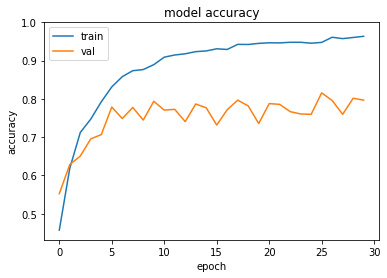

In [ ]:
# Plot accuracy history - examplary output for non-augmented 3 second segments with 20 MFCC coefficients
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(top=1)
plt.legend(['train', 'val'], loc='upper left')
#plt.savefig(root_path+'/Images/CNN_train_val_acc_mfcc_20_full_track.png')
plt.show()

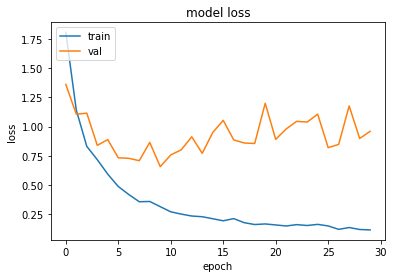

In [ ]:
# Plot loss history - examplary output for non-augmented 3 second segments with 20 MFCC coefficients
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.savefig(root_path+'/Images/CNN_train_val_loss_mfcc_20_full_track.png')
plt.show()

In [ ]:
#CNN.save(root_path+"/Models/CNN_mfcc_20_3_sec")

In [ ]:
# use to free variables after running a model

import gc
gc.collect()

33163

In [ ]:
CNN = tf.keras.models.load_model(root_path+"/Models/CNN_aug_mfcc_20_full_track")

In [ ]:
CNN.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 3306, 18, 32)      320       
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 1653, 9, 32)      0         
 g2D)                                                            
                                                                 
 batch_normalization_48 (Bat  (None, 1653, 9, 32)      128       
 chNormalization)                                                
                                                                 
 dropout_60 (Dropout)        (None, 1653, 9, 32)       0         
                                                                 
 conv2d_49 (Conv2D)          (None, 1651, 7, 64)       18496     
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 826, 4, 64)     

In [ ]:
# evaluate the CNN on the test set - examplary output for non-augmented 3 second segments with 20 MFCC coefficients
test_error, test_accuracy = CNN.evaluate(X_test, y_test, verbose = 1)
print("Accuracy on test set is: {}".format(test_accuracy))

63/63 [==============================] - 0s 5ms/step - loss: 0.9390 - accuracy: 0.8088
Accuracy on test set is: 0.8088088035583496


In [ ]:
# pick a sample to predict from the test set - examplary output for non-augmented 3 second segments with 20 MFCC coefficients
X_to_predict = X_test[100:101]
y_to_predict = int(y_test[100])

# predict sample
prediction = CNN.predict(X_to_predict)

print("Prediction is",np.argmax(prediction),"while the real label is",y_to_predict)

1/1 [==============================] - 0s 105ms/step
Prediction is 2 while the real label is 2


In [ ]:
# Confusion Matrix - examplary output for non-augmented 3 second segments with 20 MFCC coefficients
predictions = CNN.predict(X_test).argmax(axis=1)

tf.math.confusion_matrix(y_test,predictions)

63/63 [==============================] - 0s 4ms/step


<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[153,   0,   9,   0,   2,   0,   7,   5,   3,   3],
       [  0, 193,   3,   2,   1,   0,   7,   3,   3,   0],
       [ 12,   4, 154,   2,   7,   2,  10,  16,   2,   1],
       [  0,   4,   1, 154,   0,   1,   5,   4,  16,   6],
       [  6,   2,  18,   3, 146,   1,   7,  26,   8,   0],
       [  1,   0,   0,   1,   0, 192,   2,   0,   2,   3],
       [  7,   7,  19,  13,   3,   0, 122,   1,  18,   0],
       [  6,   7,   4,   5,   9,   0,   0, 183,   2,   0],
       [  4,   0,   6,   4,   1,   0,  12,   0, 154,   1],
       [  2,   0,   3,   1,   0,  11,   3,   0,  12, 165]], dtype=int32)>

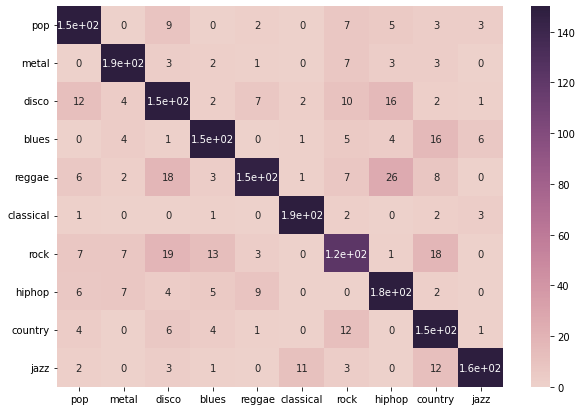

In [ ]:
# visualize confusion matrix - examplary output for non-augmented 3 second segments with 20 MFCC coefficients
array = tf.math.confusion_matrix(y_test,predictions).numpy()
df_cm = pd.DataFrame(array, index = [i for i in ["pop","metal","disco","blues","reggae","classical","rock","hiphop","country","jazz"]],
                  columns = [i for i in ["pop","metal","disco","blues","reggae","classical","rock","hiphop","country","jazz"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,vmax=150,cmap=sn.cubehelix_palette(as_cmap=True))

### CRNN

Our second model is a CRNN. We used the same core architecture as for the CNN, but added two recurrent layers after the convolutional layers this time. Here, we experimented both with LSTM as well as GRU layers, but ultimately decided to go with LSTM as we could achieve slightly better results in this configuration.

The training approach as well as the general setup is the same as for the first model. 

Some ideas on how to change the model's architecture to improve its accuracy fo this task was found in this CRNN implementation: 
https://github.com/keunwoochoi/music-auto_tagging-keras/blob/master/music_tagger_crnn.py

In [ ]:
# function to build and initialize the model
def build_CRNN(input_shape):
    # create model
    model = Sequential()
    
    # 1st conv layer
    model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape)) # num_filters/num_kernels, kernel/filter size
    model.add(MaxPool2D((3, 3), strides = (2, 2), padding = 'same')) # padding same s.t. size is equal
    model.add(BatchNormalization()) # quicker convergence and more reliable model
    model.add(Dropout(0.1))

    # 2nd conv layer
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D((3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    # 3rd conv layer
    model.add(Conv2D(128, (2, 2), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D((2, 2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    # 4th conv layer
    model.add(Conv2D(128, (2, 2), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D((2, 2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    # Reshaping
    model.add(keras.layers.Permute(((2,1,3))))
    model.add(keras.layers.Reshape((20, 128)))

    # LSTM layer
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(128, return_sequences=False))
    
    # GRU Layers - alternatively to LSTM
    #model.add(GRU(128,return_sequences=True, name = 'GRU1')) 
    #model.add(GRU(128,return_sequences=False, name = 'GRU2'))

    # Flatten 
    model.add(Flatten())
    
    # Dense Layer
    model.add(Dense(128, activation='relu')) # first dense layer decides which feature is important for which class -> fully connected layer
    model.add(Dropout(0.3)) # dropout prob = 30 %. To avoid overfitting

    # Output layer
    model.add(Dense(10, activation = 'softmax', name='output')) #num_neurons = num_classes, softmax = prob distribution of classes

    return model

In [ ]:
# Define and compile model
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]) #X_train = num_samples, num_timebins, num_MFFC/num_melscales, num_channels
CRNN = build_CRNN(input_shape)
optimizer = keras.optimizers.Adam(learning_rate= 0.001) # test different learning rates
CRNN.compile(optimizer=optimizer,
              loss = "sparse_categorical_crossentropy",
              metrics = ['accuracy'])

In [ ]:
# Train model - examplary output for augmented 3 second segments with 20 MFCC coefficients
history_CRNN = CRNN.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size=32, epochs = 30)

Epoch 1/30
875/875 [==============================] - 19s 16ms/step - loss: 1.6969 - accuracy: 0.3900 - val_loss: 1.1748 - val_accuracy: 0.5816
Epoch 2/30
875/875 [==============================] - 13s 15ms/step - loss: 1.4148 - accuracy: 0.4971 - val_loss: 0.9519 - val_accuracy: 0.6737
Epoch 3/30
875/875 [==============================] - 12s 13ms/step - loss: 1.2671 - accuracy: 0.5559 - val_loss: 0.9531 - val_accuracy: 0.6557
Epoch 4/30
875/875 [==============================] - 11s 13ms/step - loss: 1.1503 - accuracy: 0.5991 - val_loss: 0.8126 - val_accuracy: 0.6947
Epoch 5/30
875/875 [==============================] - 11s 13ms/step - loss: 1.0531 - accuracy: 0.6343 - val_loss: 0.6157 - val_accuracy: 0.7868
Epoch 6/30
875/875 [==============================] - 11s 13ms/step - loss: 0.9766 - accuracy: 0.6609 - val_loss: 0.6038 - val_accuracy: 0.7978
Epoch 7/30
875/875 [==============================] - 11s 13ms/step - loss: 0.9061 - accuracy: 0.6855 - val_loss: 0.6261 - val_accuracy:

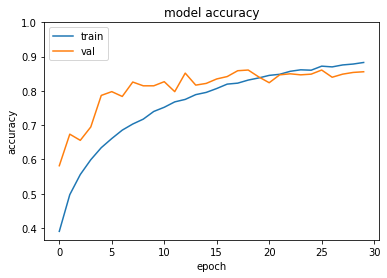

In [ ]:
# Plot accuracy history - examplary output for augmented 3 second segments with 20 MFCC coefficients
plt.plot(history_CRNN.history['accuracy'])
plt.plot(history_CRNN.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(top=1)
plt.legend(['train', 'val'], loc='upper left')
#plt.savefig(root_path+'/Images/CRNN_train_val_acc_aug_mfcc_20_3_sec.png')
plt.show()

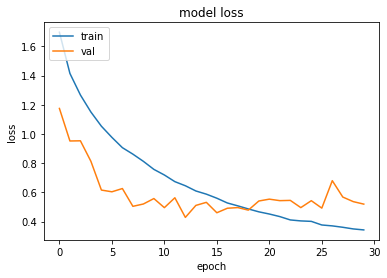

In [ ]:
# Plot loss history - examplary output for augmented 3 second segments with 20 MFCC coefficients
plt.plot(history_CRNN.history['loss'])
plt.plot(history_CRNN.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(root_path+'/Images/CRNN_train_val_loss_aug_mfcc_20_3_sec.png')
plt.show()

In [ ]:
#CRNN.save(root_path+"/Models/CRNN_aug_mfcc_20_full_track")

In [ ]:
# use to free variables after running a model

import gc
gc.collect()

13358

In [ ]:
CNN = tf.keras.models.load_model(root_path+"/Models/CNN_aug_mfcc_3_sec")

In [ ]:
CNN.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 329, 38, 32)       320       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 165, 19, 32)      0         
 g2D)                                                            
                                                                 
 batch_normalization_20 (Bat  (None, 165, 19, 32)      128       
 chNormalization)                                                
                                                                 
 dropout_25 (Dropout)        (None, 165, 19, 32)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 163, 17, 64)       18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 82, 9, 64)       

In [ ]:
CNN2 = tf.keras.models.load_model(root_path+"/Models/CNN_mfcc_20_3_sec")

In [ ]:
CNN2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 329, 18, 32)       320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 165, 9, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 165, 9, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_10 (Dropout)        (None, 165, 9, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 163, 7, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 82, 4, 64)       

In [ ]:
CRNN = tf.keras.models.load_model(root_path+"/Models/CRNN_mfcc_3_sec")

In [ ]:
CRNN.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_88 (Conv2D)          (None, 329, 38, 32)       320       
                                                                 
 max_pooling2d_88 (MaxPoolin  (None, 165, 19, 32)      0         
 g2D)                                                            
                                                                 
 batch_normalization_88 (Bat  (None, 165, 19, 32)      128       
 chNormalization)                                                
                                                                 
 dropout_97 (Dropout)        (None, 165, 19, 32)       0         
                                                                 
 conv2d_89 (Conv2D)          (None, 163, 17, 64)       18496     
                                                                 
 max_pooling2d_89 (MaxPoolin  (None, 82, 9, 64)      

In [ ]:
CRNN2 = tf.keras.models.load_model(root_path+"/Models/CRNN_mfcc_20_3_sec")

In [ ]:
CRNN2.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_96 (Conv2D)          (None, 329, 18, 32)       320       
                                                                 
 max_pooling2d_96 (MaxPoolin  (None, 165, 9, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_96 (Bat  (None, 165, 9, 32)       128       
 chNormalization)                                                
                                                                 
 dropout_106 (Dropout)       (None, 165, 9, 32)        0         
                                                                 
 conv2d_97 (Conv2D)          (None, 163, 7, 64)        18496     
                                                                 
 max_pooling2d_97 (MaxPoolin  (None, 82, 4, 64)      

In [ ]:
# evaluate the CRNN on the test set - examplary output for augmented 3 second segments with 20 MFCC coefficients
test_error, test_accuracy = CRNN.evaluate(X_test, y_test, verbose = 1)
print("Accuracy on test set is: {}".format(test_accuracy))

63/63 [==============================] - 0s 7ms/step - loss: 0.5028 - accuracy: 0.8639
Accuracy on test set is: 0.8638638854026794


In [ ]:
# pick a sample to predict from the test set - examplary output for augmented 3 second segments with 20 MFCC coefficients
X_to_predict = X_test[100:101]
y_to_predict = int(y_test[100])

# predict sample
prediction = CRNN.predict(X_to_predict)

print("Prediction is",np.argmax(prediction),"while the real label is",y_to_predict)

1/1 [==============================] - 1s 722ms/step
Prediction is 2 while the real label is 2


In [ ]:
# Confusion Matrix - examplary output for augmented 3 second segments with 20 MFCC coefficients
predictions = CRNN.predict(X_test).argmax(axis=1)

tf.math.confusion_matrix(y_test,predictions)

63/63 [==============================] - 0s 5ms/step


<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[165,   0,   6,   1,   3,   0,   1,   2,   3,   1],
       [  0, 193,   2,   0,   0,   0,   6,  10,   0,   1],
       [ 10,   0, 179,   1,   5,   0,   5,   6,   4,   0],
       [  0,   3,   1, 175,   0,   0,   2,   1,   8,   1],
       [  6,   0,   6,   3, 180,   1,   4,  13,   3,   1],
       [  1,   0,   0,   0,   0, 192,   1,   0,   3,   4],
       [  6,   7,  12,  18,   5,   2, 130,   0,   7,   3],
       [  8,   2,   4,   4,  10,   0,   2, 186,   0,   0],
       [  4,   0,   4,   9,   3,   0,  12,   0, 149,   1],
       [  0,   0,   0,   4,   0,   7,   3,   0,   6, 177]], dtype=int32)>

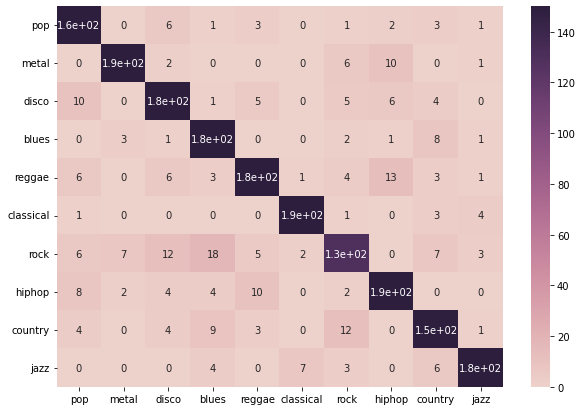

In [ ]:
# Visualize Confusion Matrix - examplary output for augmented 3 second segments with 20 MFCC coefficients
array = tf.math.confusion_matrix(y_test,predictions).numpy()
df_cm = pd.DataFrame(array, index = [i for i in ["pop","metal","disco","blues","reggae","classical","rock","hiphop","country","jazz"]],
                  columns = [i for i in ["pop","metal","disco","blues","reggae","classical","rock","hiphop","country","jazz"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,vmax=150,cmap=sn.cubehelix_palette(as_cmap=True))
#plt.savefig(root_path+'/Images/CNN_confusion_mfcc_20_3_sec.png')